<a href="https://colab.research.google.com/github/anerocha/aws-lambda-athena/blob/main/Profissao_Analista_dedados_M42_Exercicio_parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Pipeline de Dados do Telegram II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Ingestão;</li>
  <li>ETL;</li>
  <li>Apresentação;</li>
  <li>Storytelling.</li>
</ol>

---

# **Exercícios**

## 1\. Ingestão

Replique as atividades da aula 1.

1.1. Crie um `bucket` no `AWS S3` para o armazenamento de dados crus, não se esqueça de adicionar o sufixo `-raw`.

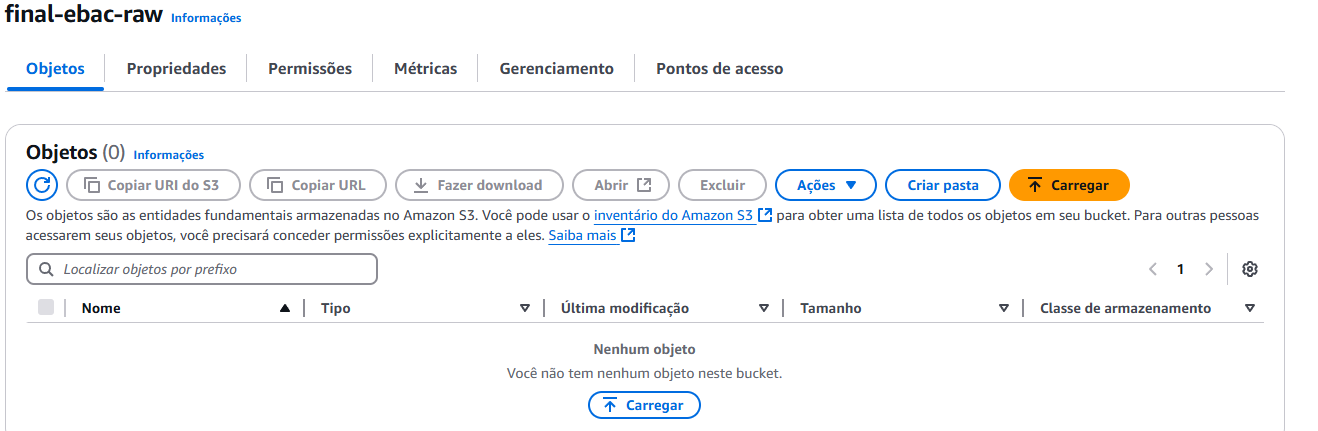

1.2. Crie uma função no `AWS Lambda` para recebimento das mensagens e armazenamento no formato JSON no `bucket` de dados crus. Não se esqueça de configurar as variáveis de ambiente e de adicionar as permissão de interação com `AWS S3` no `AWS IAM`.

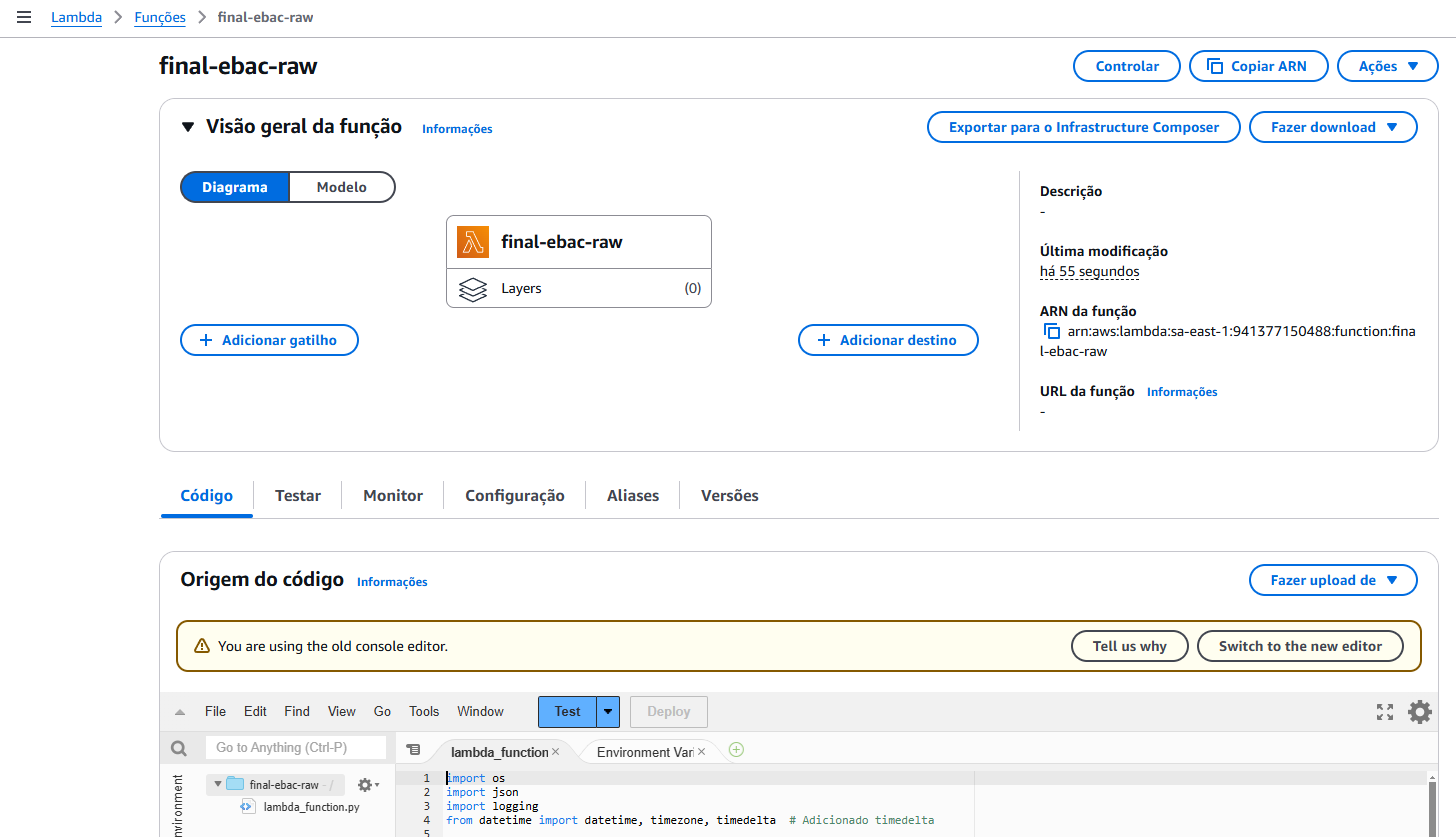

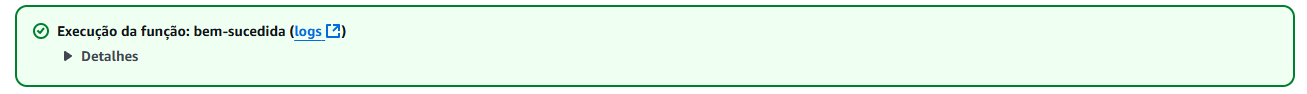

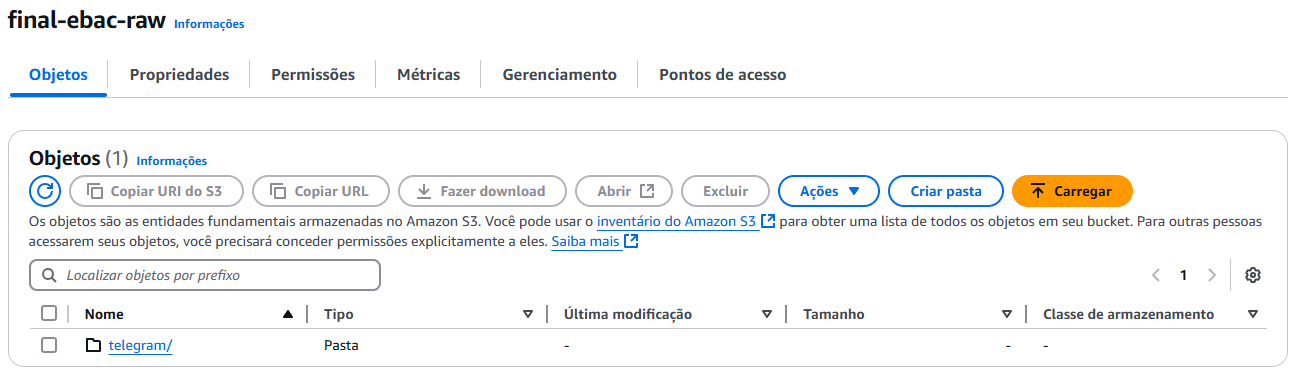

> **Nota**: Para testar a função com evento do próprio `AWS Lambda`, substitua o código `message = json.loads(event["body"])` por `message = event`. Lembre-se que o primeiro só faz sentido na integração com o `AWS API Gateway`.

1.3. Crie uma API no `AWS API Gateway` a conecte a função do `AWS Lambda`, conforme apresentado na aula.

> **Nota**: não disponibilize o endereço da API gerada.

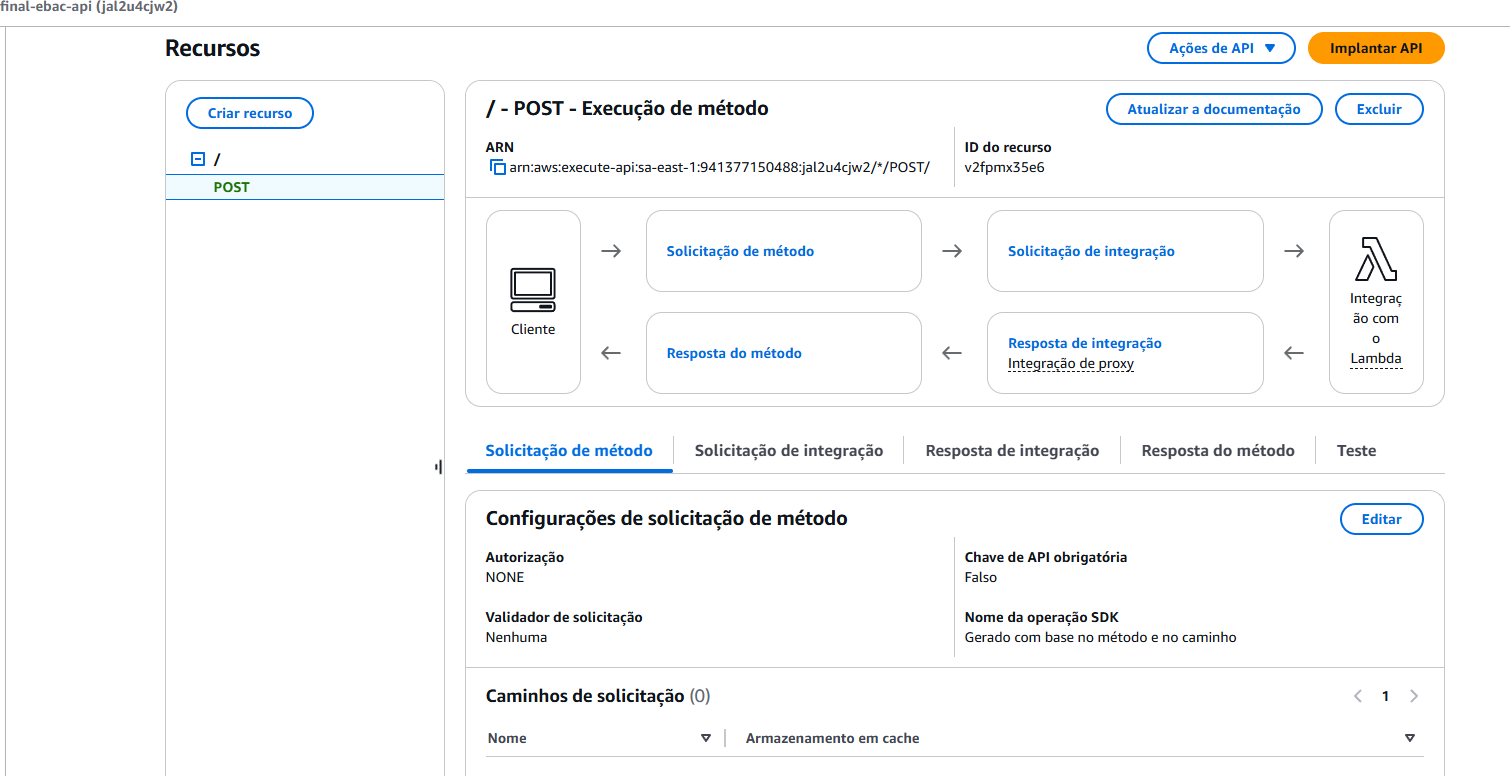

1.4. Configura o *webhook* do *bot* através do método `setWebhook` da API de *bots* do **Telegram**. utilize o endereço da API criada no `AWS API Gateway`. Utilize o método `getWebhookInfo` para consultar a integração.

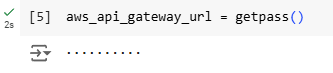

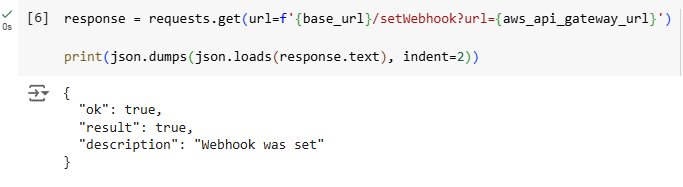

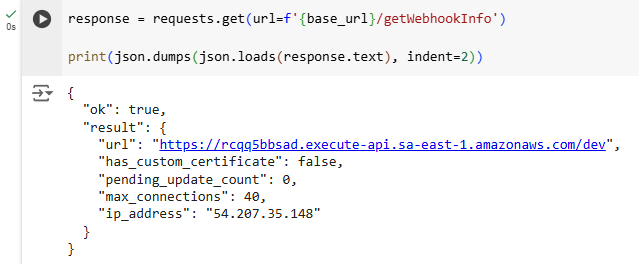

> **Nota**: não disponibilize o *token* de acesso ao seu *bot* da API de *bots* do **Telegram**.

## 2\. ETL

Replique as atividades da aula 2.

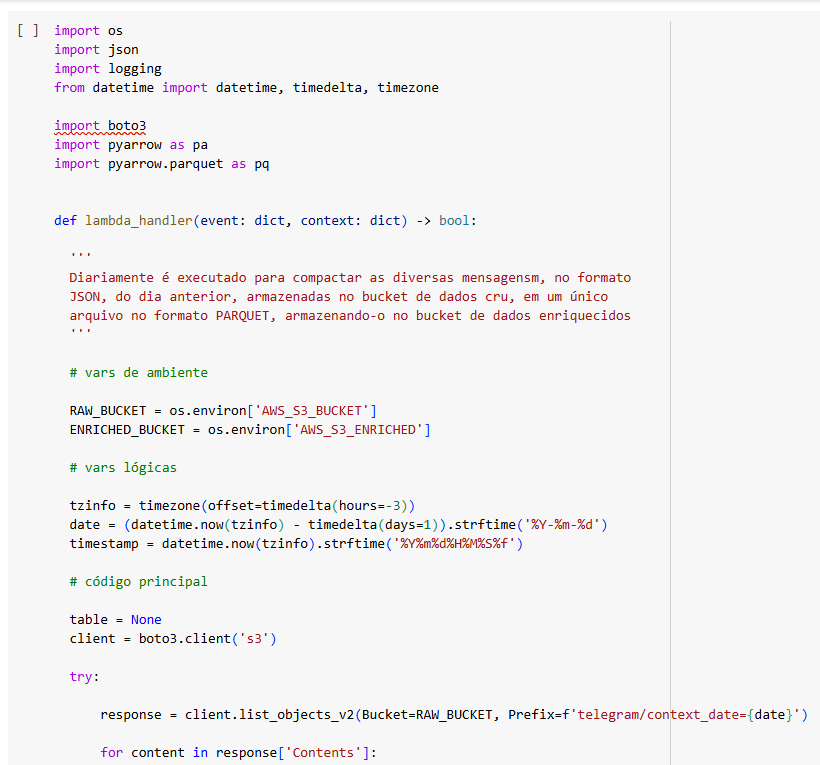

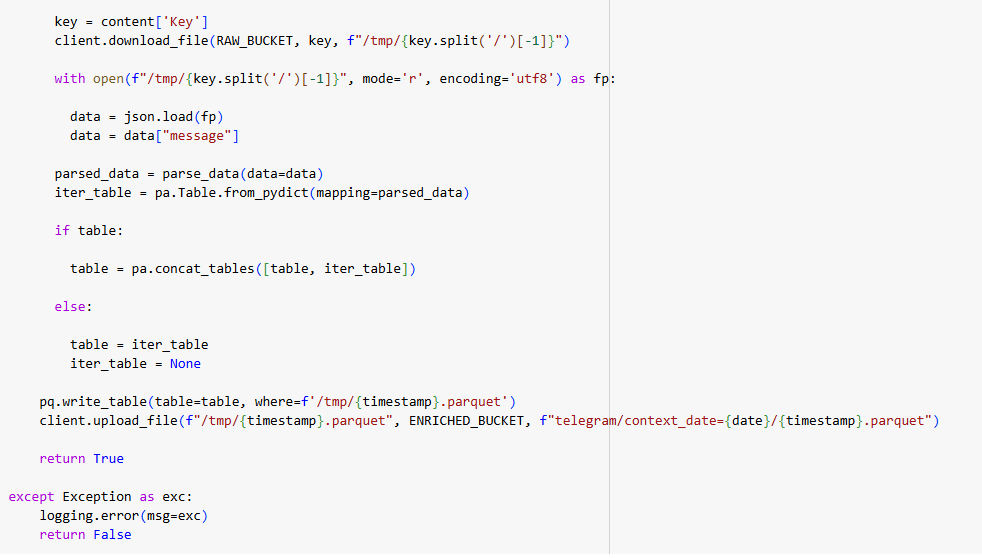

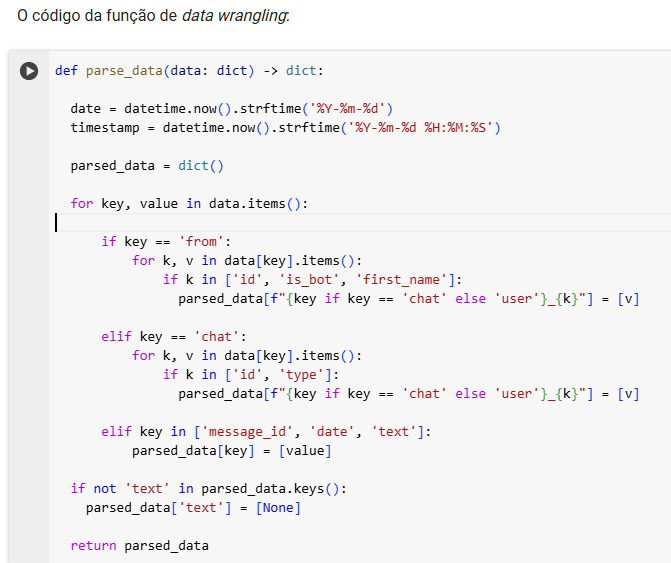

2.1. Crie um `bucket` no `AWS S3` para o armazenamento de dados enriquecidos, não se esqueça de adicionar o sufixo `-enriched`.

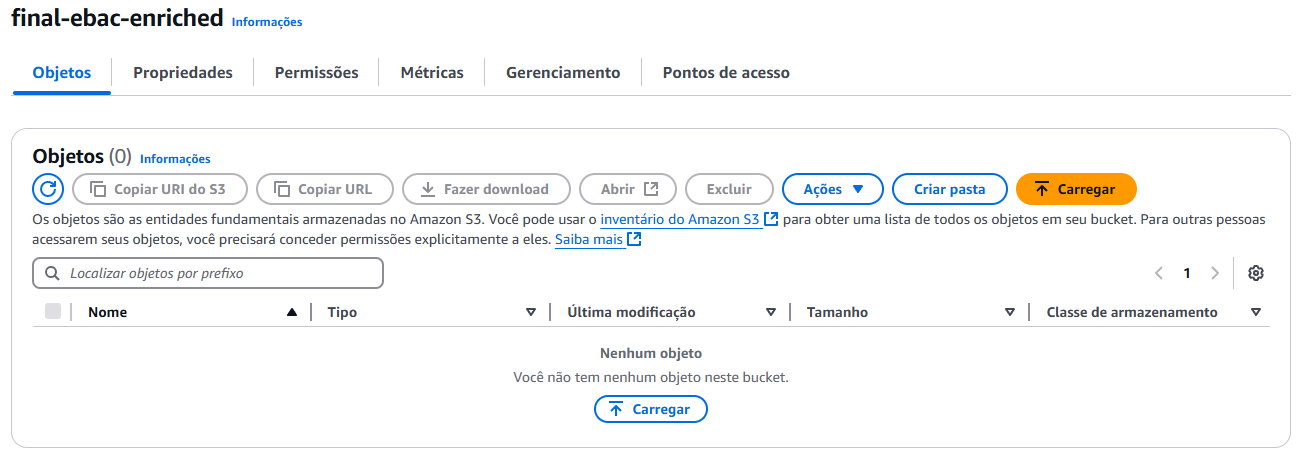

2.2. Cria uma função no `AWS Lambda` para processar as mensagens JSON de uma única partição do dia anterior (D-1), armazenadas no *bucket* de dados crus. Salve o resultado em um único arquivo PARQUET, também particionado por dia. Não se esqueça de configurar as variáveis de ambiente, de adicionar as permissão de interação com `AWS S3` no `AWS IAM`, de configurar o *timeout* e de adicionar a *layer* com o código do pacote Python PyArrow.

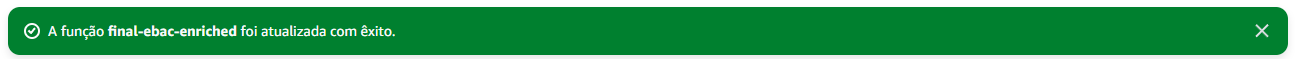

* Camadas

Por fim, note que o código da função utiliza o pacote Python PyArrow. Contudo, o ambiente padrão do AWS Lambda possui poucos pacotes externos instalado, como o pacote Python boto3, logo o PyArrow não será encontrado e a execução da função falhará. Existem algumas formas de adicionar pacotes externos no ambiente de execução do AWS Lambda, um deles é a criação de camadas ou layers, onde podemos fazer o upload dos pacotes Python direto na plataforma ou através de um bucket do AWS S3. Vamos então seguir com a última opção, onde teremos que:

* Criar um bucket no AWS S3;
* Fazer o upload do código do pacote Python do PyArrow (download neste link);
* Criar layer e conectar na função.

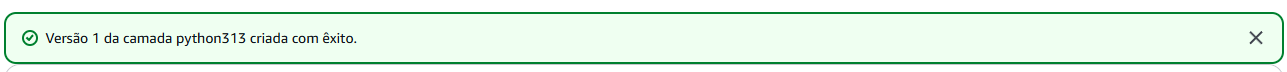

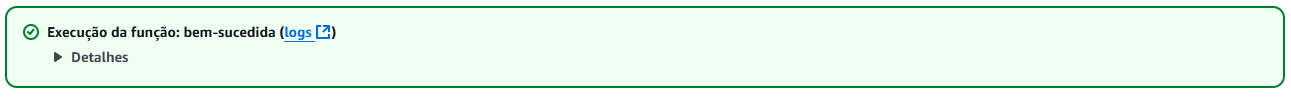

> **Nota**: Para testar a função, substitua o código `date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')` por `date = (datetime.now(tzinfo) - timedelta(days=0)).strftime('%Y-%m-%d')`, permitindo assim o processamento de mensagens de um mesmo dia.

2.3. Crie uma regra no `AWS Event Bridge` para executar a função do `AWS Lambda` todo dia a meia noite no horário de Brasília (GMT-3).

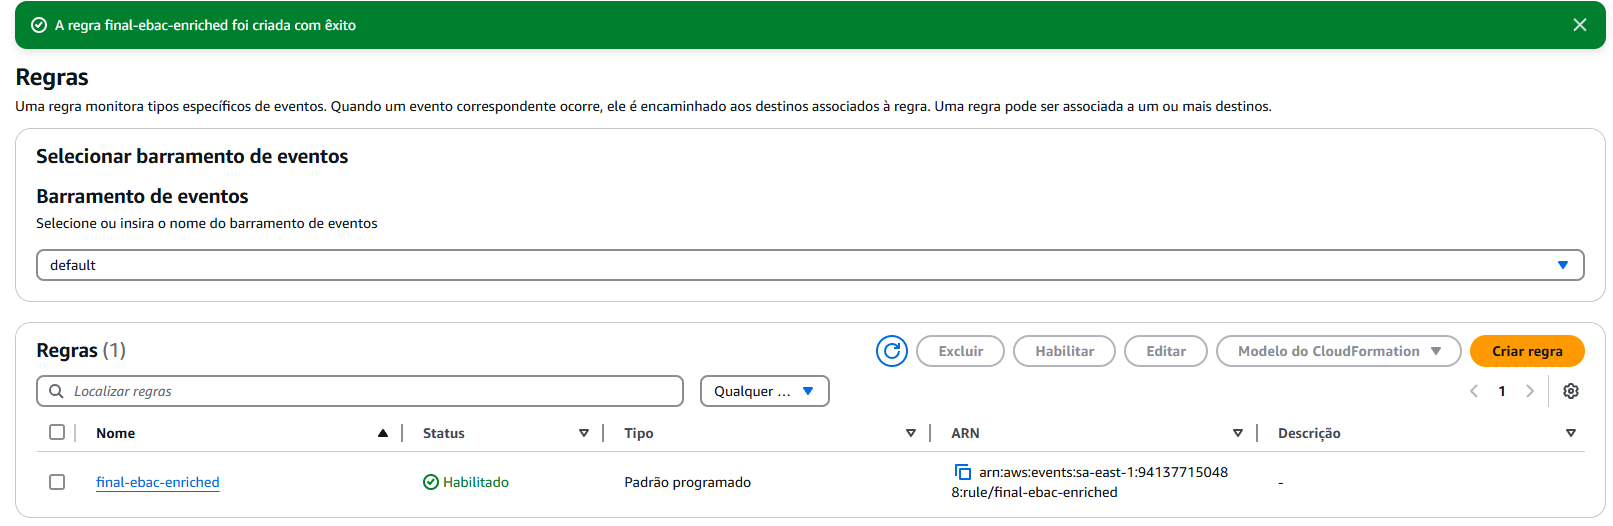

## 3\. Apresentação

Replique as atividades da aula 3.

3.1. Cria a tabela no `AWS Athena` que aponte para os dados armazenados no bucket enriquecido do `AWS S3`.

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://final-ebac-enriched/telegram/'
```

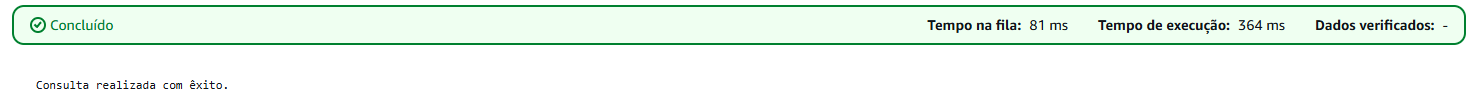

3.2. Execute o comando `MSCK REPAIR TABLE <nome-tabela>` para carregar as partições.

```sql
MSCK REPAIR TABLE `telegram`;
```

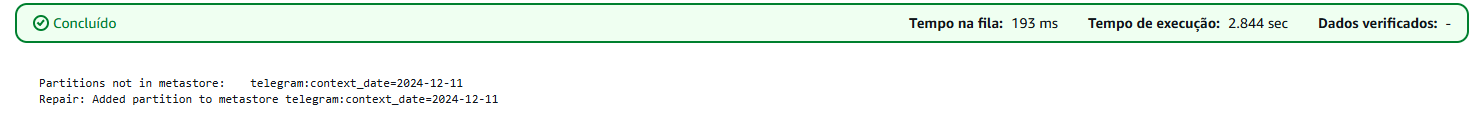

3.3. Execute as consultas SQL para explorar os dados.

* E consulte as 10 primeiras linhas para observar o resultado.

```sql
SELECT * FROM `telegram` LIMIT 10;
```

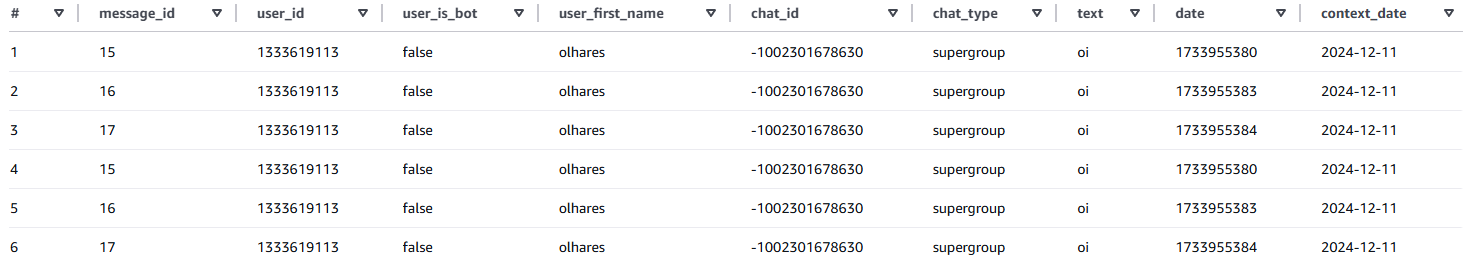

* **Analytics**

* Quantidade de mensagens por dia.

```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

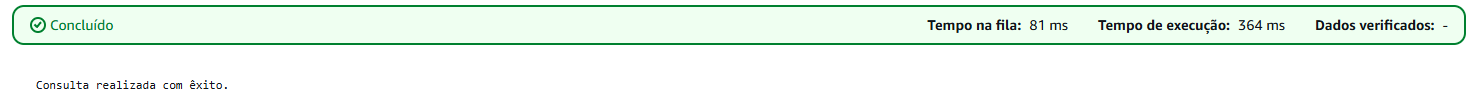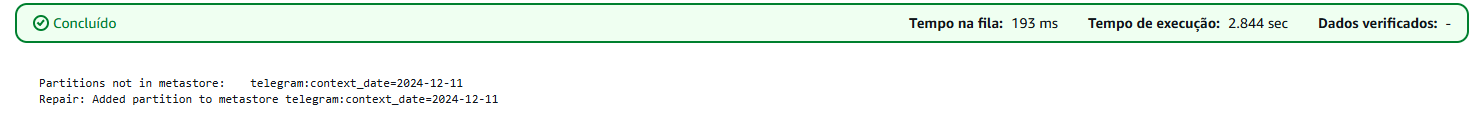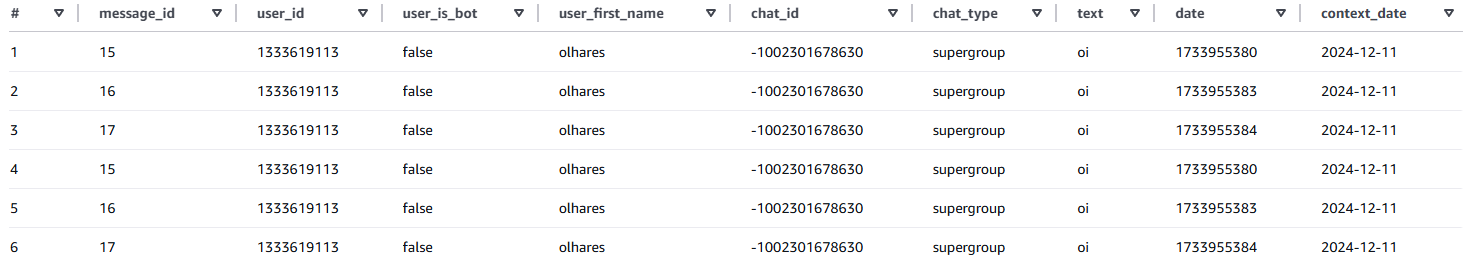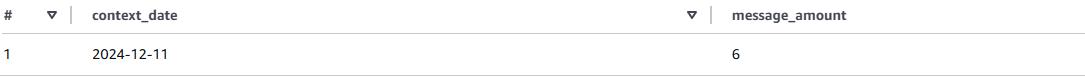

* Quantidade de mensagens por usuário por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

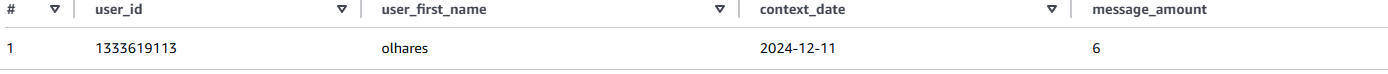

* Média do tamanho das mensagens por usuário por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

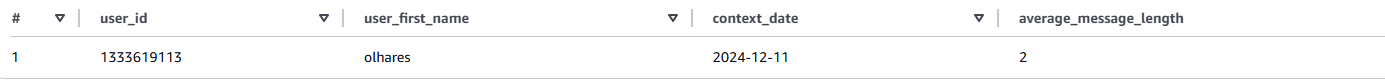

* Quantidade de mensagens por hora por dia da semana por número da semana.

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

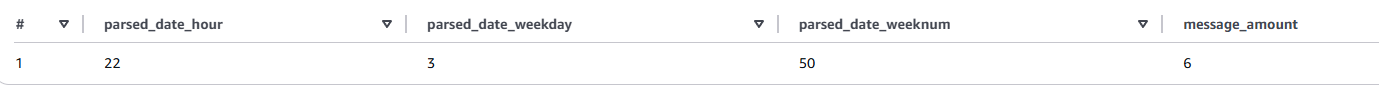

## 4\. Storytelling

A Jornada dos Dados - Do Telegram para a Análise em Tempo Real
Imagine que temos uma empresa que deseja processar e analisar as mensagens enviadas em um canal do Telegram. Esse fluxo de dados precisa ser organizado, enriquecido e disponibilizado para análise de forma eficiente. Para isso, utilizamos a arquitetura de dados da AWS, que envolve Lambda, S3, Athena, entre outras ferramentas, para transformar dados brutos em insights valiosos. Vamos contar essa história passo a passo:

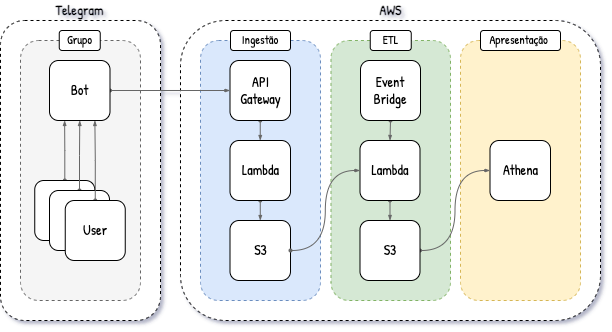



* O Início da Jornada: Coletando Dados do Telegram
Tudo começa com o envio de mensagens por usuários no Telegram. Essas mensagens são capturadas e armazenadas em um bucket S3, que chamamos de bucket cru (RAW). Cada mensagem contém informações como o ID do usuário, o texto da mensagem, o tipo de chat, entre outros dados. Essas mensagens são gravadas em arquivos JSON e armazenadas em diretórios específicos do S3, agrupadas por data de contexto (indicando quando as mensagens foram enviadas).



* A Transformação Diária: O Papel do AWS Lambda
Todo esse processo precisa ser automatizado e realizado de forma diária. Para isso, utilizamos uma função do AWS Lambda, que é acionada uma vez por dia para pegar todos os arquivos JSON do dia anterior (dados do D-1). Isso acontece de forma totalmente automatizada, graças a uma ferramenta chamada AWS EventBridge, que agenda a execução da função todos os dias em horários específicos.

Quando a função Lambda é acionada, ela se conecta ao bucket S3 onde as mensagens do Telegram estão armazenadas. Ela então percorre cada arquivo, faz o download de cada mensagem e começa o processo de transformação dos dados.



* A Transformação dos Dados: De JSON para Parquet
A função Lambda tem a tarefa de transformar os dados brutos (em formato JSON) em um formato mais eficiente para análise. Esse formato é o Parquet, um tipo de arquivo columnar que é muito mais eficiente para consultas analíticas. Durante esse processo, a função Lambda pega as mensagens, extraí e organiza as informações necessárias — como o ID do usuário, o nome do usuário, o texto da mensagem, entre outros — e armazena tudo isso em uma tabela do PyArrow, uma biblioteca Python que ajuda a manipular dados de forma eficiente.

O arquivo Parquet gerado é então armazenado em um bucket S3 diferente, chamado de bucket enriquecido. Esse bucket contém os dados já transformados e prontos para análise.



* O Acesso aos Dados: O Papel do AWS Athena
Agora que temos os dados organizados e armazenados em um formato eficiente (Parquet), precisamos disponibilizá-los para as equipes de análise e ciência de dados. Para isso, utilizamos o AWS Athena, uma ferramenta que permite consultar dados armazenados no S3 usando SQL.

Ao configurar uma tabela externa no Athena, podemos acessar todos os dados que foram carregados para o bucket enriquecido. Isso cria uma interface SQL para os analistas, permitindo que eles façam consultas sobre os dados. Por exemplo, eles podem querer saber quantas mensagens foram enviadas por dia ou por usuário, ou até mesmo a média de tamanho das mensagens.



* A Exploração dos Dados: Consultas Analíticas no Athena
Com os dados agora acessíveis através do Athena, os analistas podem explorar essas informações com consultas SQL simples. Algumas possíveis análises incluem:

Quantidade de mensagens por dia: Quantas mensagens foram enviadas no Telegram em cada dia.
Quantidade de mensagens por usuário: Qual é a distribuição de mensagens enviadas pelos usuários ao longo dos dias.
Tamanho médio das mensagens por usuário: Qual o tamanho médio das mensagens enviadas pelos usuários ao longo do tempo.
Análise temporal: Analisar quantas mensagens foram enviadas por hora do dia ou por dia da semana.
Essas consultas permitem extrair insights valiosos para a tomada de decisão, como identificar quais usuários estão mais engajados ou quais dias da semana têm maior volume de mensagens.



* Manutenção e Expansão
À medida que novos dados são coletados diariamente, novas partições de dados são adicionadas ao bucket S3 e ao Athena. O AWS EventBridge garante que a função Lambda seja executada automaticamente todos os dias para processar as mensagens do dia anterior. A cada novo conjunto de dados, os analistas têm acesso a dados cada vez mais completos, permitindo que continuem explorando e extraindo insights ao longo do tempo.



Resumo da Jornada:
Coleta de Dados: Mensagens do Telegram são armazenadas em arquivos JSON no S3 (bucket cru).
Processamento Diário: Uma função Lambda é acionada diariamente para baixar, transformar e compactar os dados em Parquet.
Enriquecimento: Os dados processados são armazenados em um bucket S3 enriquecido, prontos para análise.
Análise: O Athena oferece uma interface SQL para que os analistas possam explorar os dados de maneira simples e eficiente.
Automatização e Crescimento: Todo o processo é automatizado, com a função Lambda rodando todos os dias, mantendo o pipeline de dados em constante atualização.